# K-means 
This notebook is to test and visualize the k-means method, as well as the K-median and DBSCAN

- Divide by Regime
- Divide by day/night

A tester dans ce notebook:
- Plotter distribution variable de chaque variable
- Regarder a quoi correspond les 2 petits clusters (plot variable)
- Inverse Transform PCA
- K-means + K-median + comparer
- Plus petit cluster
- Cas seulement pour 1 regime
- K-means pur chaque regime

In [ ]:
import pandas as pd
import os
import warnings
import seaborn as sns 
import matplotlib.pyplot as plt 
import sys
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Filter out warnings
warnings.filterwarnings("ignore")

sys.path.append('../../')

from cool_train.data_loading import correct_column_types

# Additional time features
from cool_train.feature_engineering import add_time_features, add_lagged_features, create_regimes

In [ ]:
%load_ext autoreload
%autoreload 2

# Data Loading

In [ ]:
df = pd.read_csv('../../dataset/Train169/Train169.csv',sep=';')

# Data Casting
df = correct_column_types(df)

# Remove useless columns
useless_cols = ['IsInvalidLine', 'IsTreated', 'ID_Org','id','vehicle_id','Insert_Datetime','mapped_veh_id_Org','Is_Meteo_Retrieved',
                'RS_E_RPM_Delta_Percent','RS_E_OilPress_Delta_Percent', 'RS_E_WatTemp_Delta_Percent','RS_E_InAirTemp_Delta_Percent',
                'RS_T_OilTemp_Delta_Percent','Is_OutOfOrder','Is_OneEngineOnly', 'Sensors_NB_Fail_PC1', 'Sensors_NB_Fail_PC2'] # Too much NaNs
                
df = df.drop(useless_cols, axis=1)

# Remove Out-of-Range values
df = df[df['OutOfRange_NB_PC1'] == 0]
df = df[df['OutOfRange_NB_PC2'] == 0]
df = df.drop(['OutOfRange_NB_PC1','OutOfRange_NB_PC2'], axis=1)
df

In [ ]:
# Drop NaNs
original_rows = len(df)
df_cleaned = df.dropna()
rows_removed = original_rows - len(df_cleaned)
print(f"Number of NaNs rows removed: {rows_removed}")

In [ ]:
# Uniform Median-Resampling
df_cleaned = df_cleaned.set_index('timestamps_UTC')
df_cleaned = df_cleaned.resample('1t').median()

# Drop the segments where there is no data
#df_cleaned = df_cleaned.dropna(how='all')
df_cleaned# 

In [ ]:
# Adding the Time-Based Features
df_cleaned['timestamps_UTC'] = df_cleaned.index 
df_time = add_time_features(df_cleaned)
df_time = df_time.drop('timestamps_UTC',axis=1 )

In [ ]:
df_time.columns 

In [ ]:
# Adding Lag Features
add_lag_feats_flag= True 

if add_lag_feats_flag:
       variables_for_lag = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2',
              'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC1',
              'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2',
              'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2','RS_E_InAirTemp_Delta', 'RS_E_OilPress_Delta', 'RS_E_RPM_Delta',
              'RS_E_WatTemp_Delta', 'RS_T_OilTemp_Delta']
       lags = [1, 2]
       df_time = add_lagged_features(df_time, variables_for_lag, lags)
       df_time

Problems with Adding Lag-features:
- Increased Dimensionality: Adding lagged features increases the dimensionality of the dataset. This might be problematic if the number of observations is limited compared to the number of features, leading to potential overfitting.

- Correlation: Lagged features are often highly correlated with the original features. High multicollinearity can lead to unstable coefficient estimates and difficulties in interpreting the importance of individual features.

- Handling Missing Values: If your data contains gaps or missing values, handling them appropriately becomes crucial. The presence of missing values in lagged features may complicate the training of machine learning models.

In [ ]:
df_time[['RS_E_RPM_PC2','RS_E_RPM_PC2_lag2','RS_E_RPM_PC2_lag1']]

# Selection of the variables

In [ ]:
# Get the top 10 correlated variable pairs
top_correlations = df_time.corr().unstack().sort_values(ascending=False).drop_duplicates()[1:20]

# Display the result
print(f"Top 10 correlated variable pairs for train 169:")
print(top_correlations)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np 

# Assuming df is your DataFrame with features
threshold = 0.8  # Choose an appropriate threshold
corr_matrix = df_time.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation above the threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('Removed highly correlated features: ')
print(to_drop)

# Drop the highly correlated features
df_filtered = df_time.drop(to_drop, axis=1)

In [ ]:
top_correlations = df_filtered.corr().unstack().sort_values(ascending=False).drop_duplicates()[1:20]
# Display the result
print(f"Top 10 correlated variable pairs for train 169:")
print(top_correlations)

In [ ]:
# Drop useless variables
df_filtered = df_filtered.drop(['lat','lon'],axis=1)

In [ ]:
def remove_low_variance(df, threshold=0.1):
    # Use VarianceThreshold to remove features with low variance
    selector = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    
    # Fit the selector on the data
    selector.fit(df)
    
    # Get the columns that are dropped
    dropped_columns = df.columns[~selector.get_support()]
    
    # Transform the data to get the filtered DataFrame
    df_filtered = pd.DataFrame(selector.transform(df), columns=df.columns[selector.get_support()], index=df.index)
    
    # Print the columns that were dropped
    print(f'Dropped columns: {dropped_columns}')
    
    return df_filtered

# Remove variables with low variance
df_filtered = remove_low_variance(df_filtered)

In [ ]:
df_filtered = create_regimes(df_filtered)
df_filtered

In [ ]:
df_filtered.columns 

# Scaling features

In [ ]:
df_filtered = df_filtered.dropna()

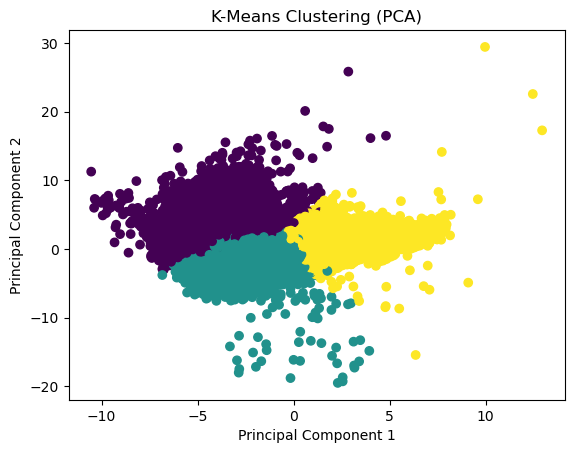

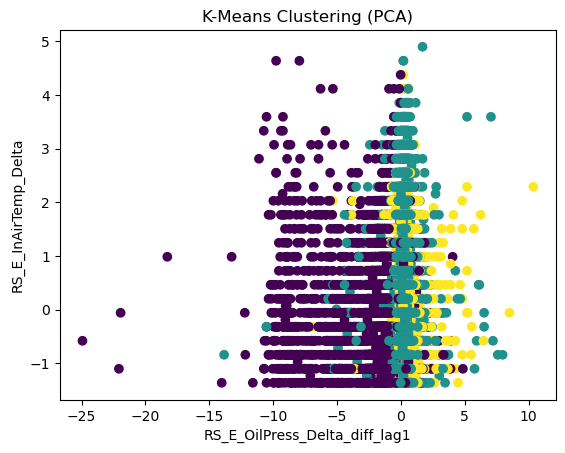

In [284]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Identify categorical columns
categorical_columns = df_filtered.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_filtered, columns=categorical_columns, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

# Apply K-Means
k = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(df_scaled)


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_filtered['cluster'], cmap='viridis')
plt.title('K-Means Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
    
plt.scatter(df_scaled['RS_E_OilPress_Delta_diff_lag1'], df_scaled['RS_E_InAirTemp_Delta'], c=df_filtered['cluster'], cmap='viridis')
plt.title('K-Means Clustering (PCA)')
plt.xlabel('RS_E_OilPress_Delta_diff_lag1')
plt.ylabel('RS_E_InAirTemp_Delta')
plt.show()
    

# K-Means

In [295]:
# Select Regime we want to Analyze
df_filtered = df_filtered[df_filtered['Regime']=='Cruising']

In [307]:
# Remove Time-Index
df_kmeans = df_filtered.reset_index(drop=True)

# Identify categorical columns
categorical_columns = df_kmeans.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_kmeans, columns=categorical_columns, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Apply K-Means on the principal components
kmeans = KMeans(n_clusters=3, random_state=42)
df_kmeans['cluster'] = kmeans.fit_predict(pca_result)

# Inverse transform the principal components to obtain the reconstructed features
reconstructed_features = pca.inverse_transform(pca_result)
df_reconstructed = pd.DataFrame(reconstructed_features, columns=df_scaled.columns)

# Inverse transform the principal components to obtain the reconstructed features
reconstructed_features = pca.inverse_transform(pca_result)
df_reconstructed = pd.DataFrame(reconstructed_features, columns=df_scaled.columns)



In [309]:
df_kmeans['cluster'].value_counts(normalize=True)

1    0.447006
0    0.422911
2    0.130083
Name: cluster, dtype: float64

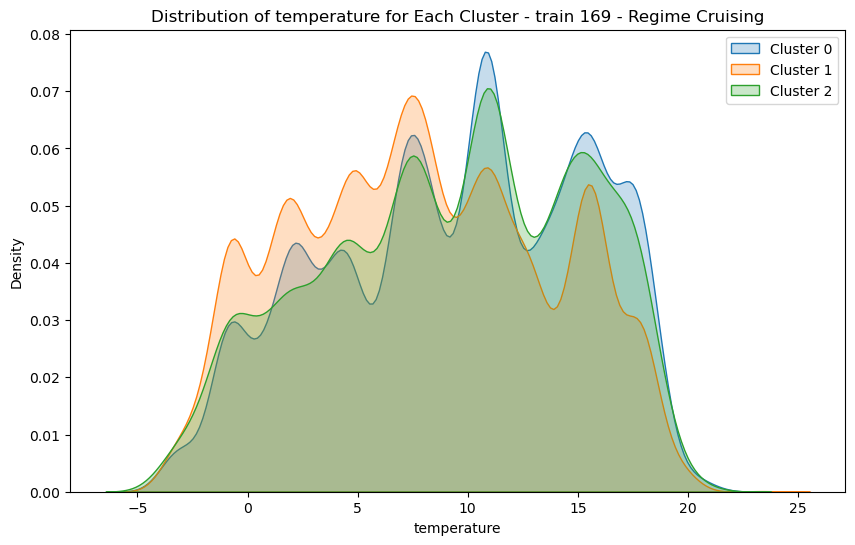

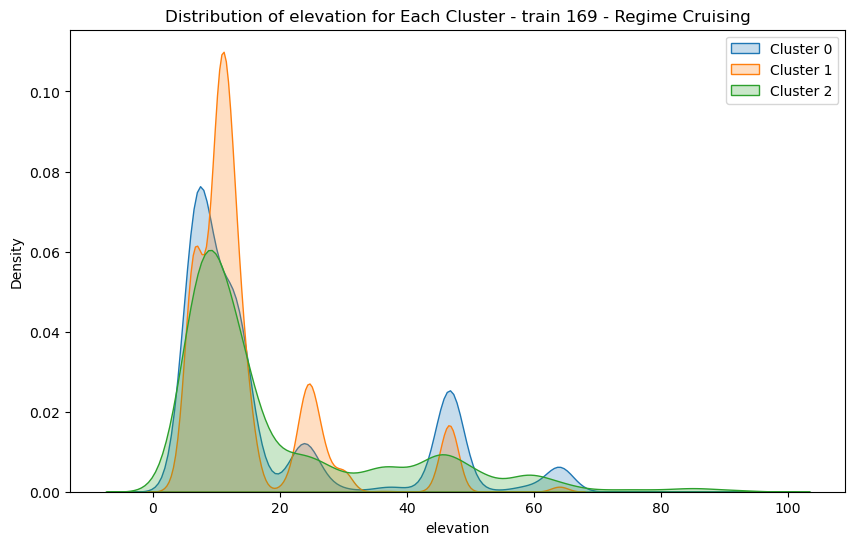

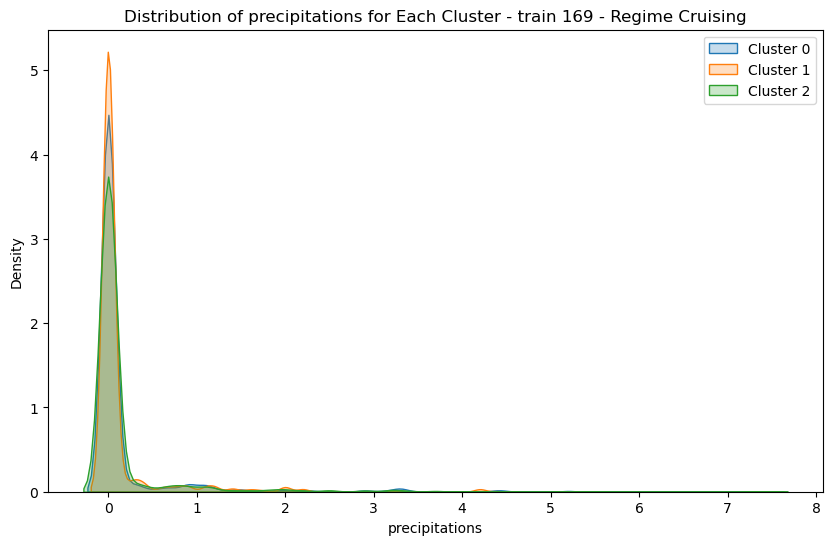

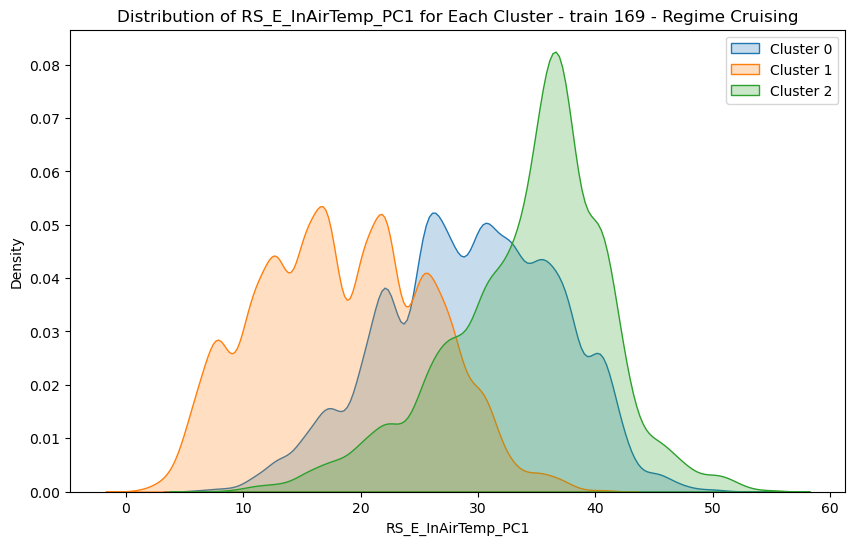

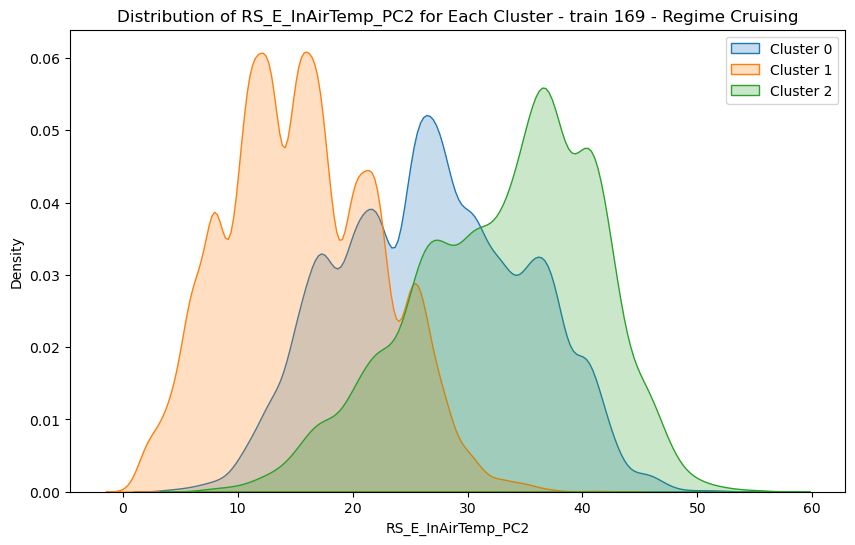

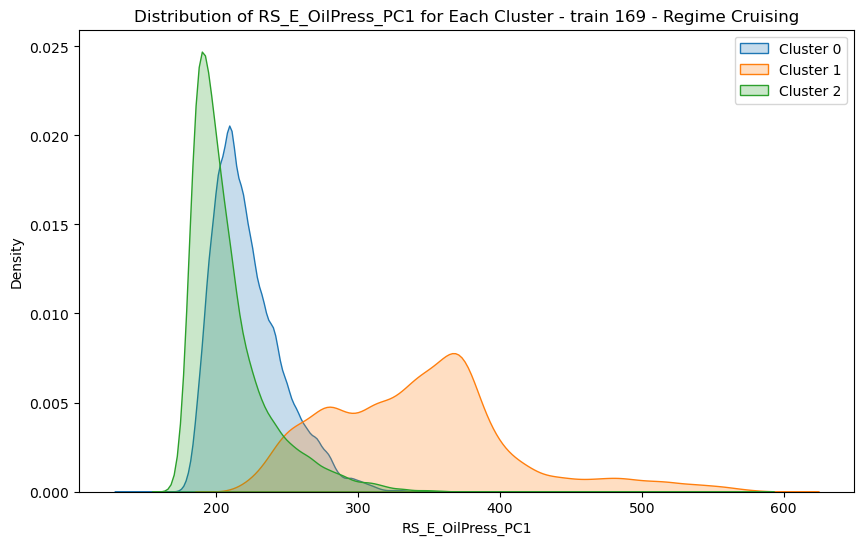

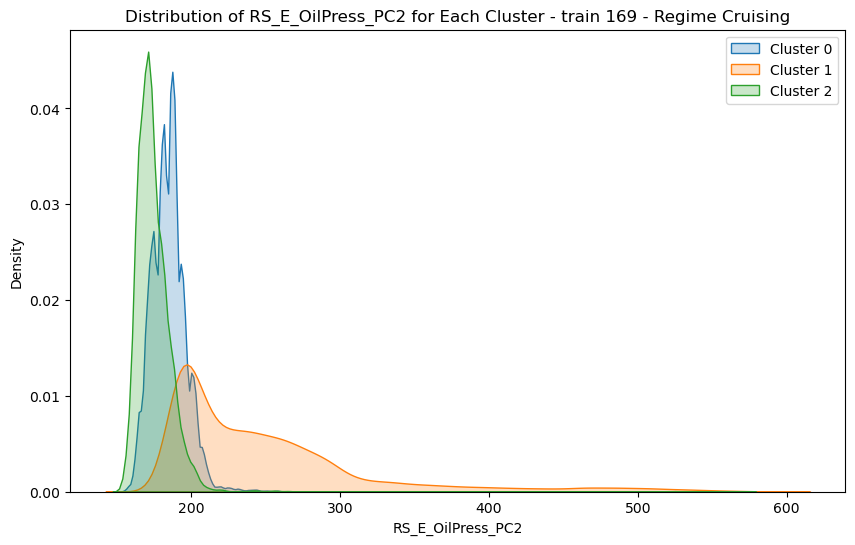

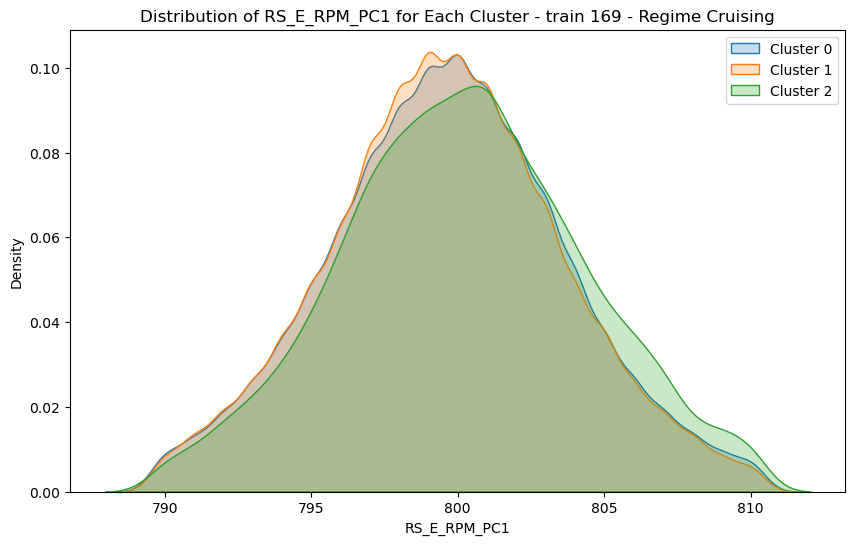

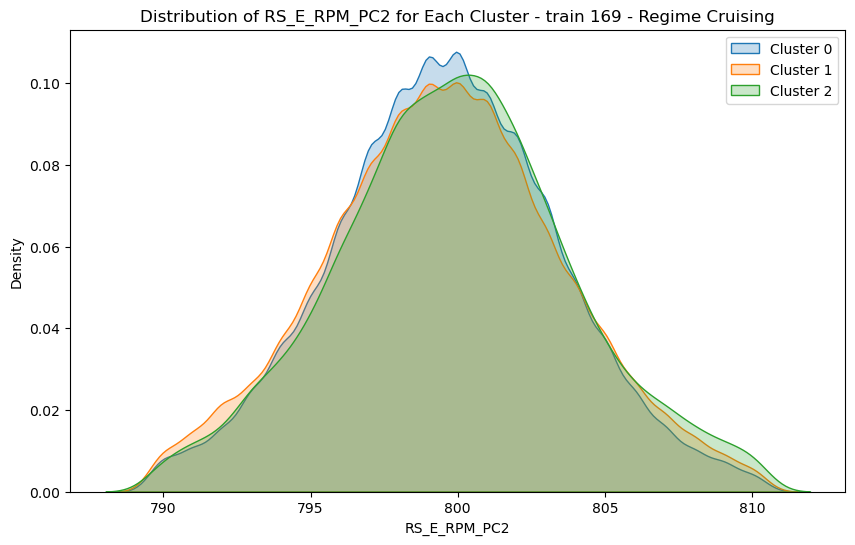

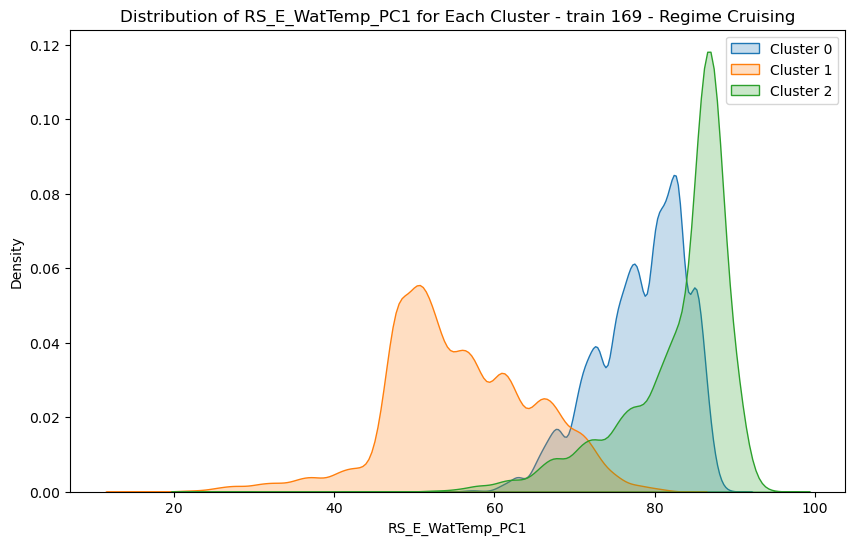

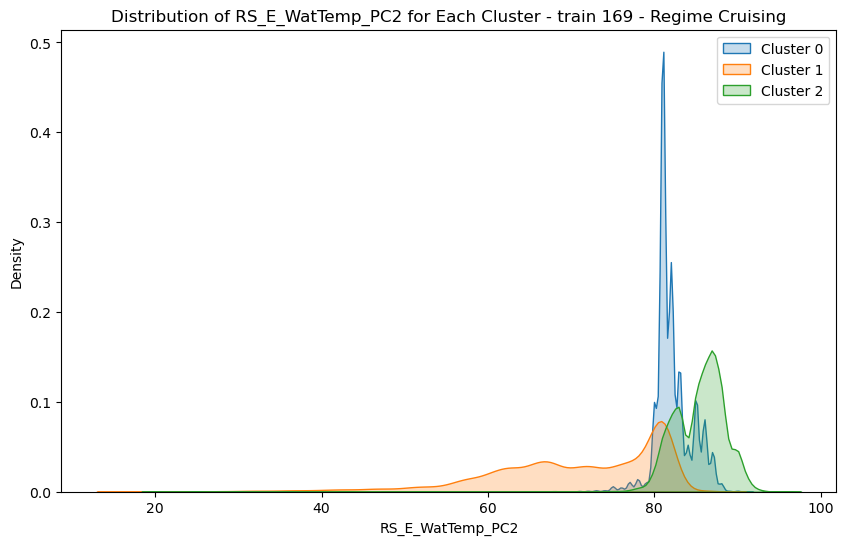

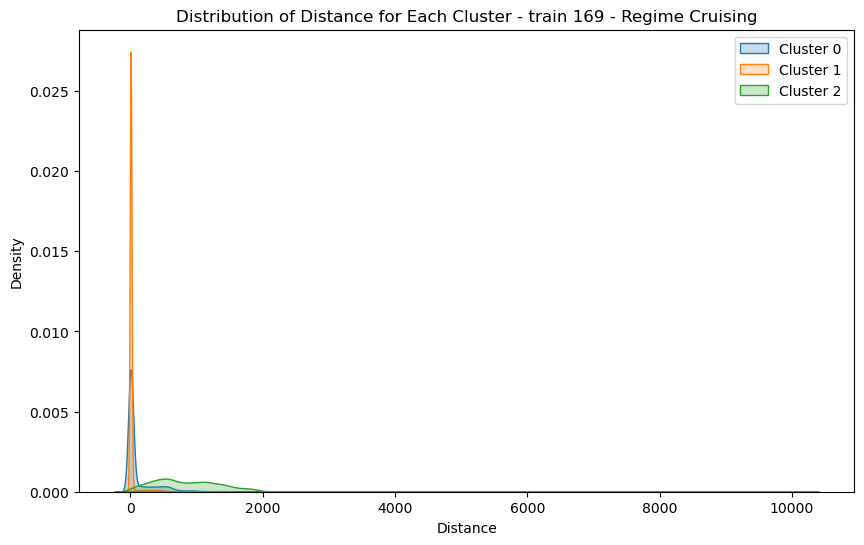

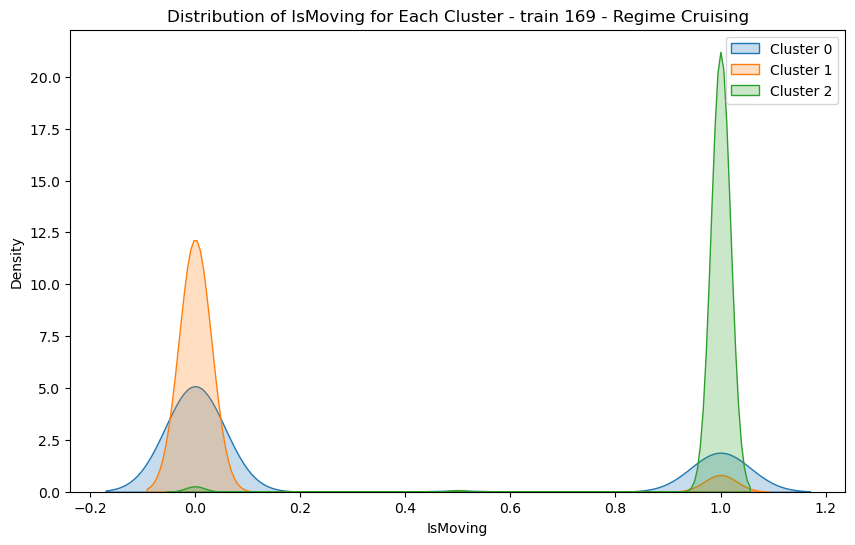

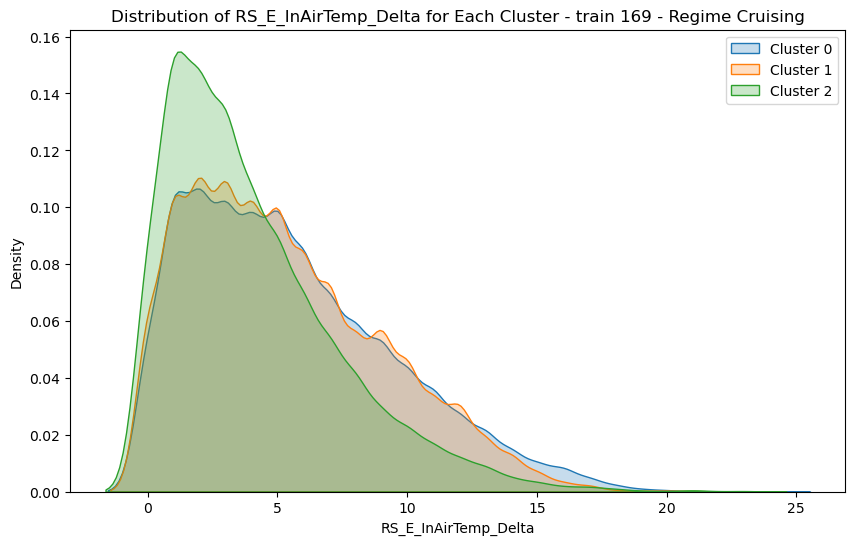

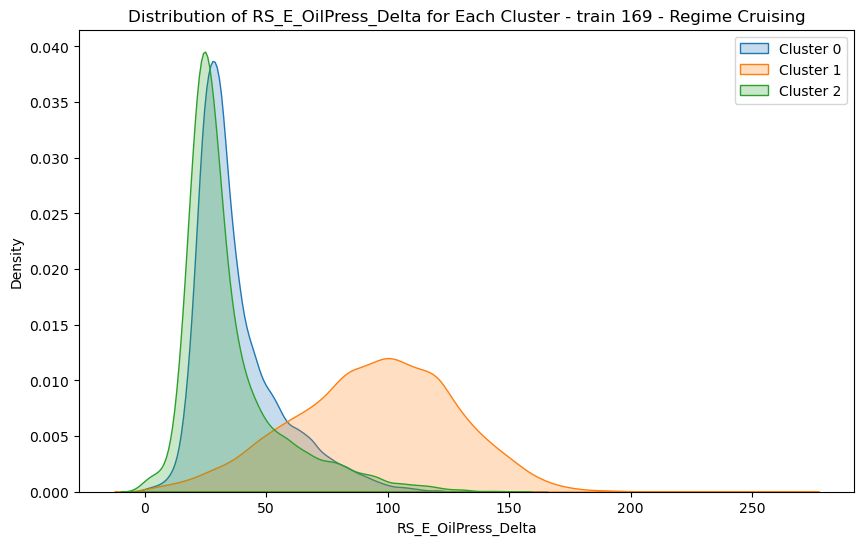

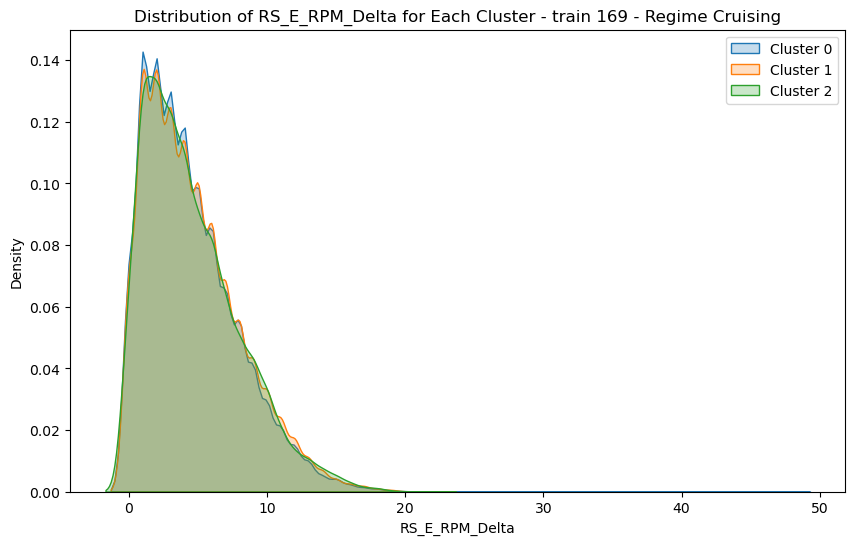

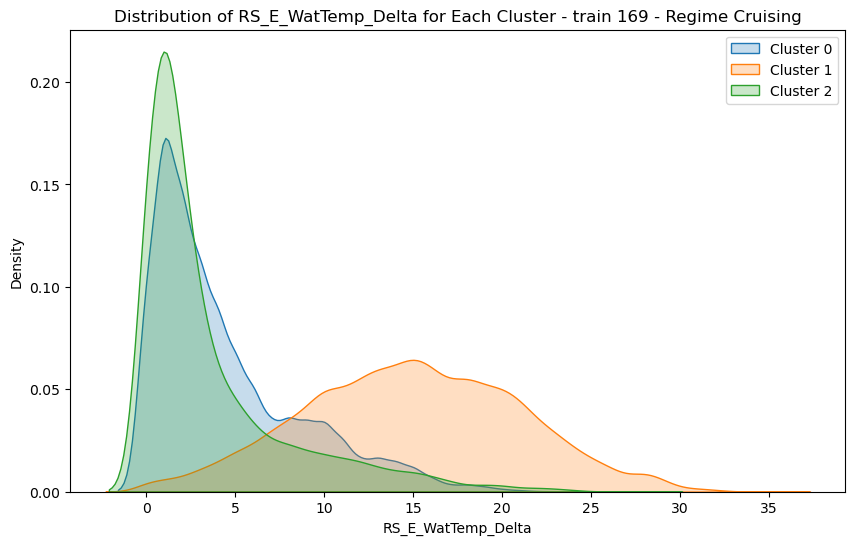

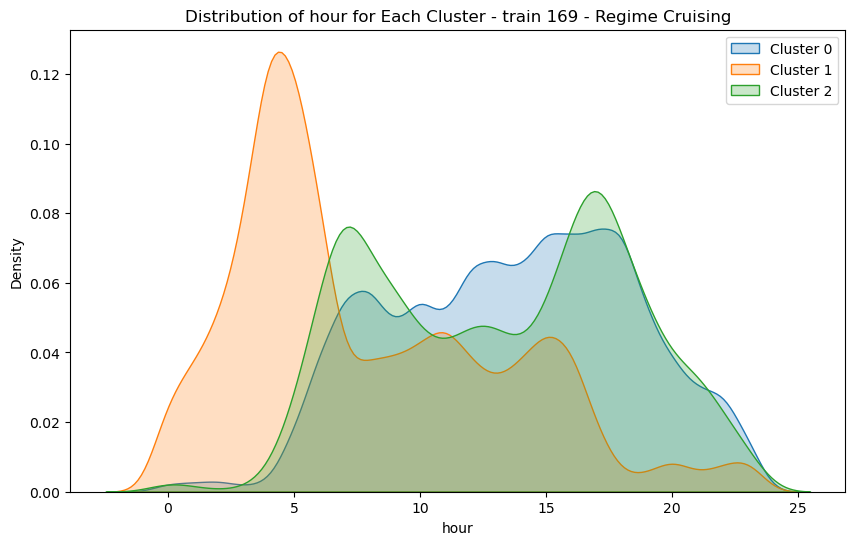

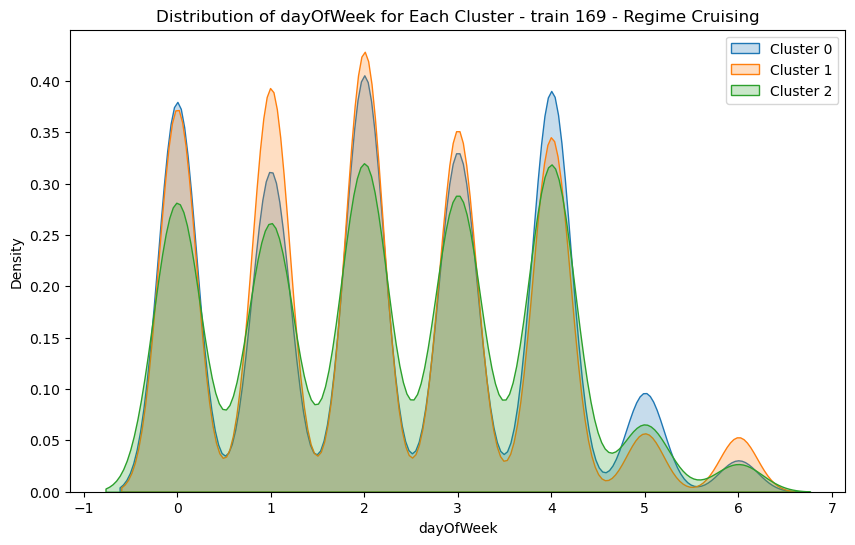

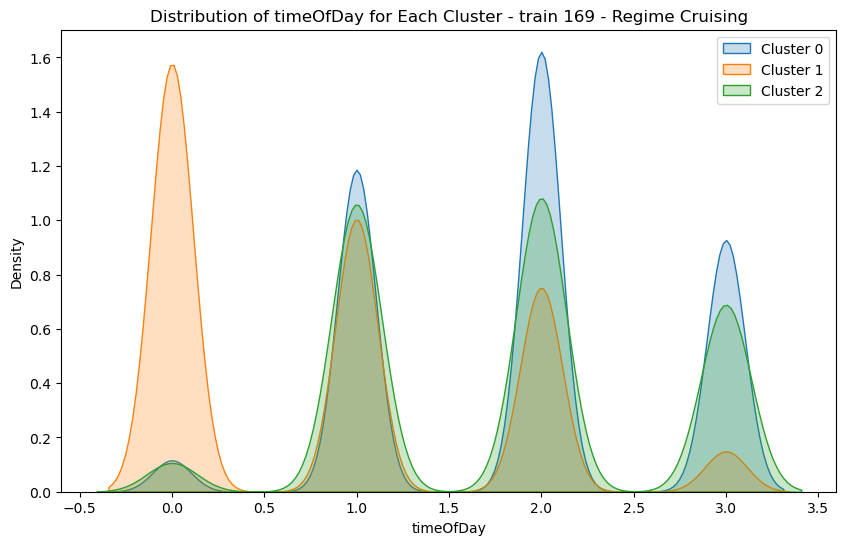

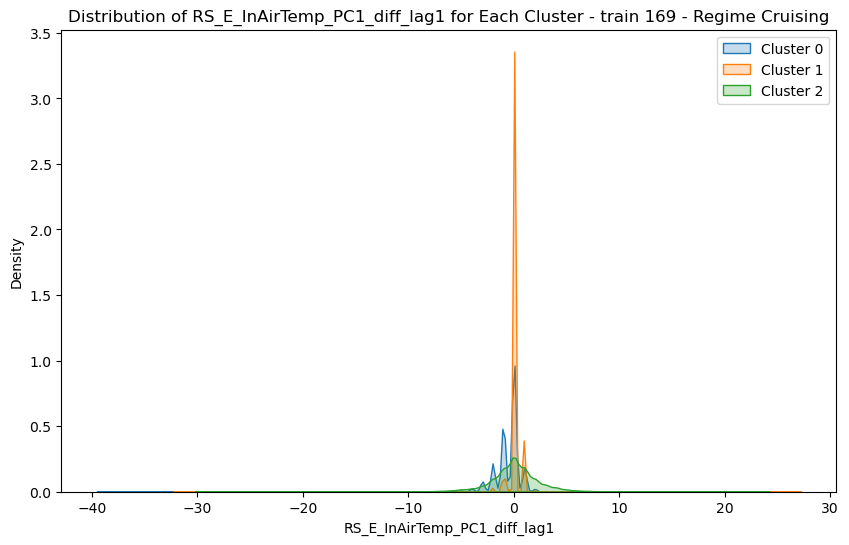

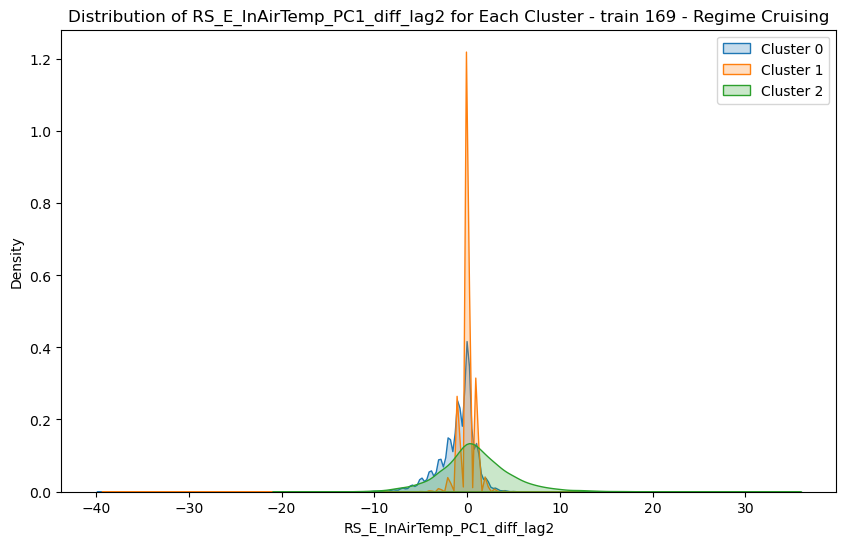

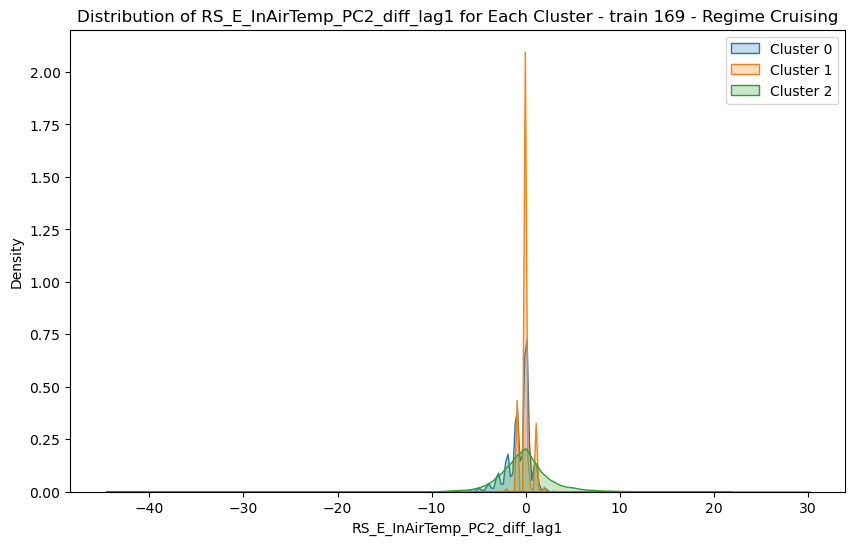

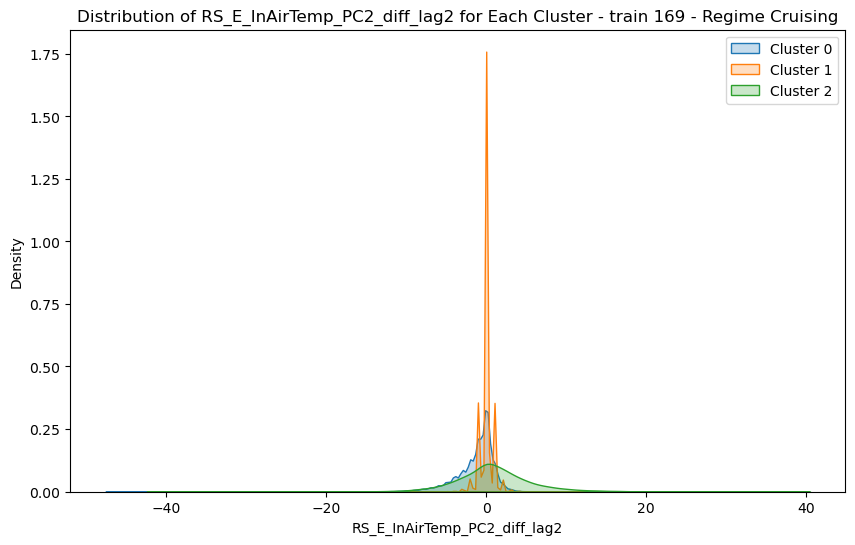

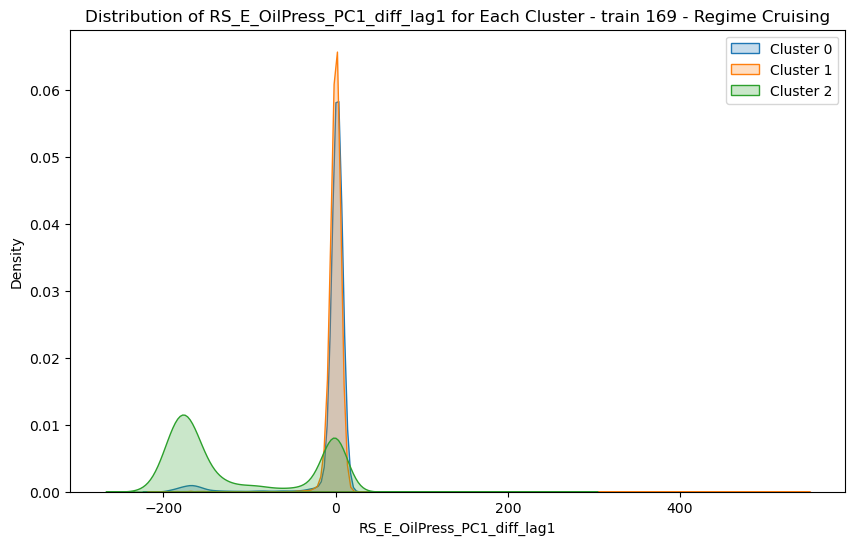

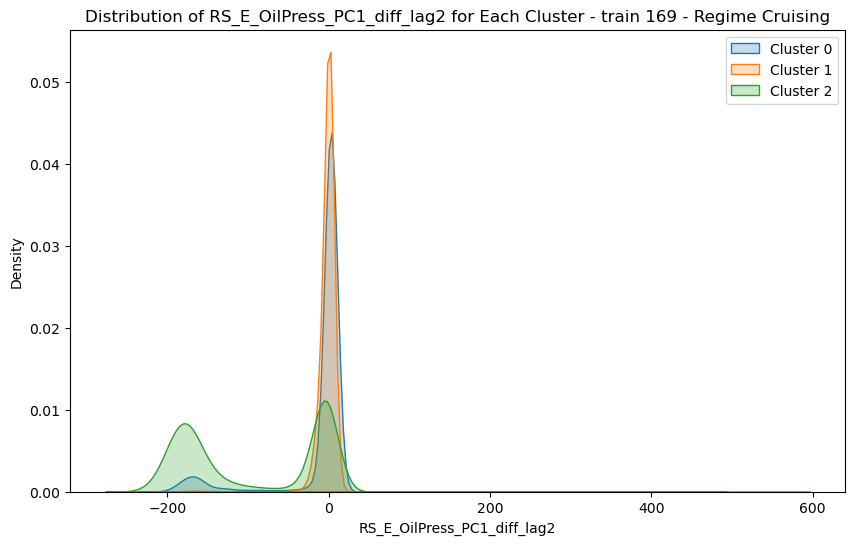

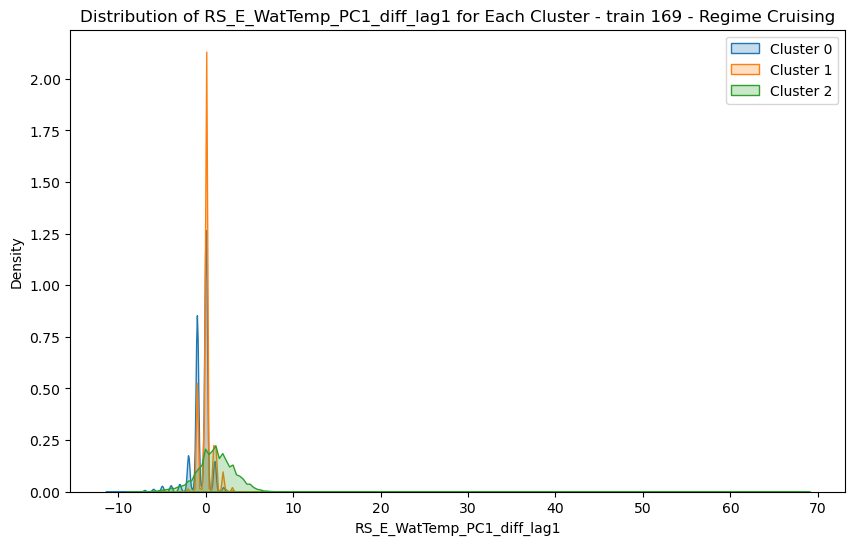

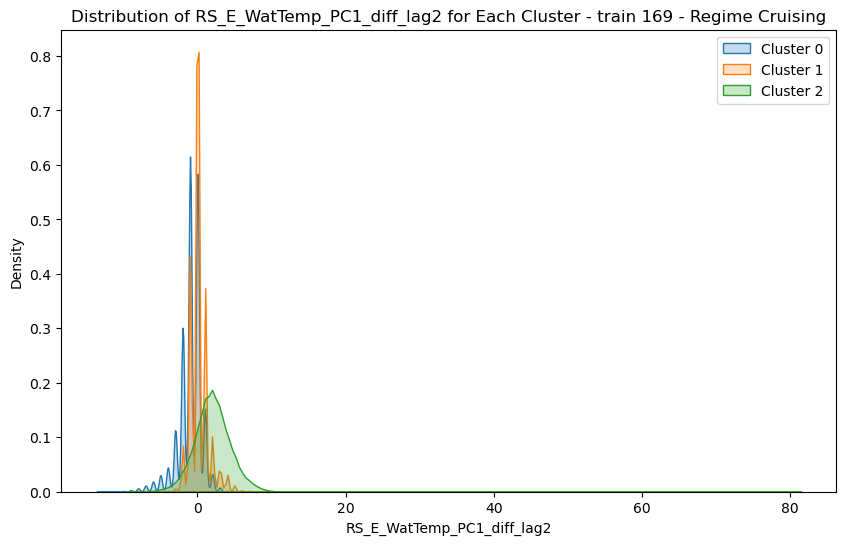

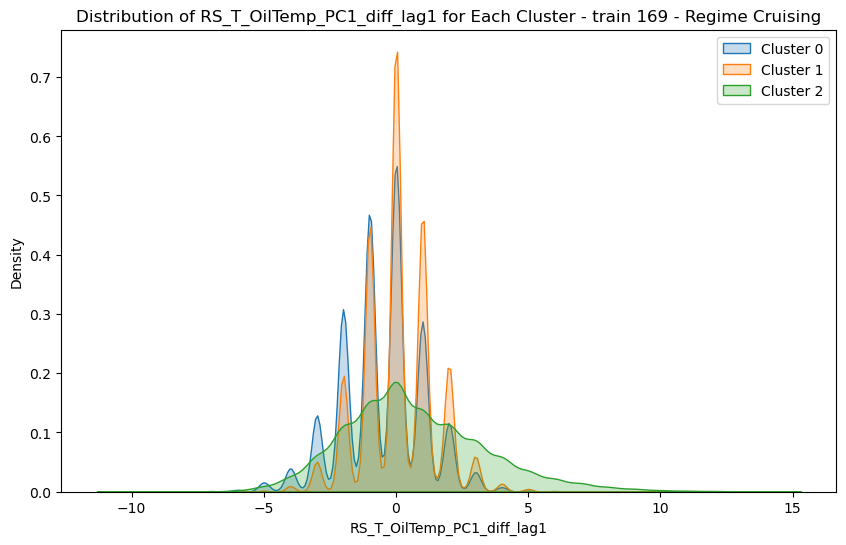

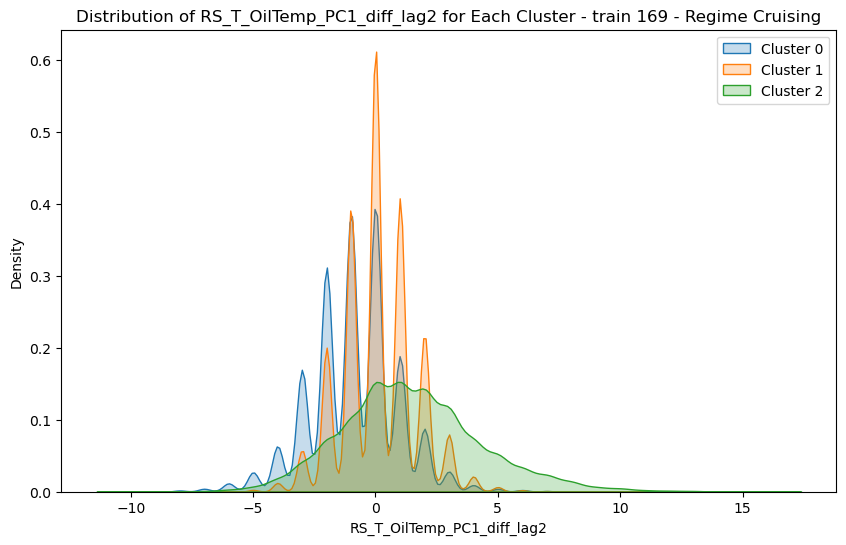

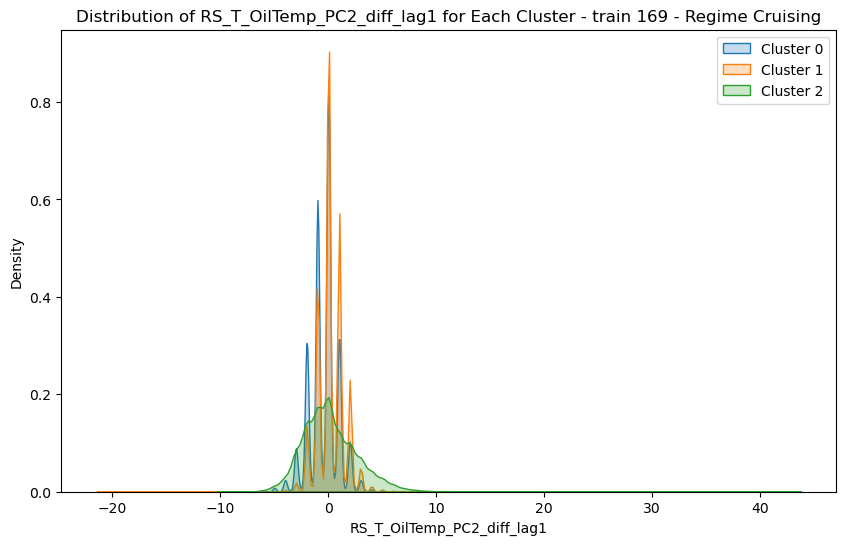

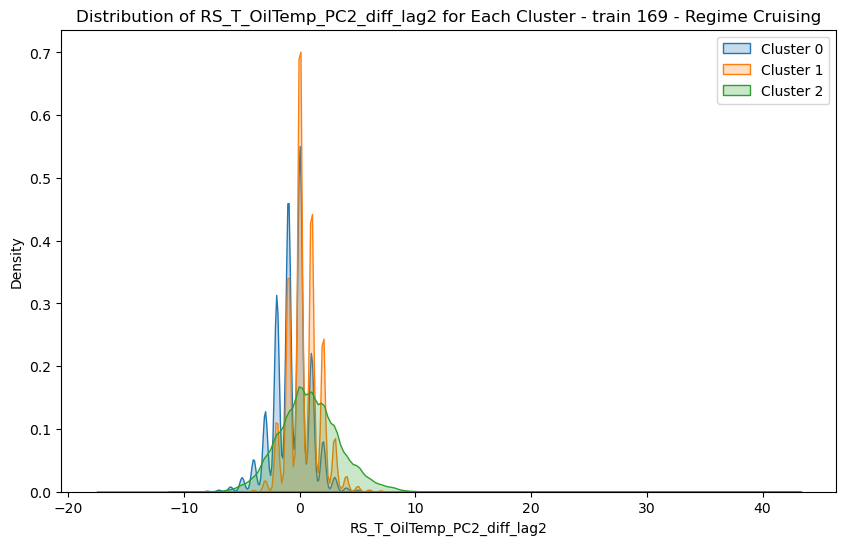

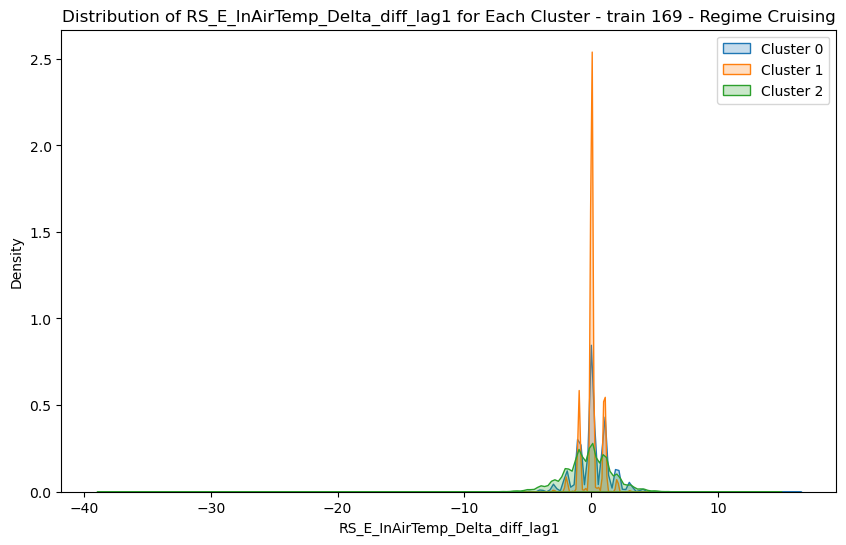

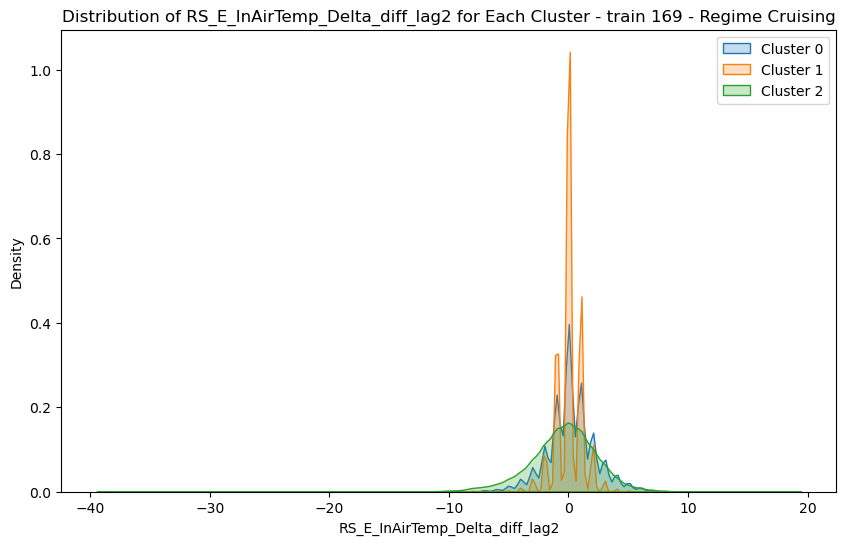

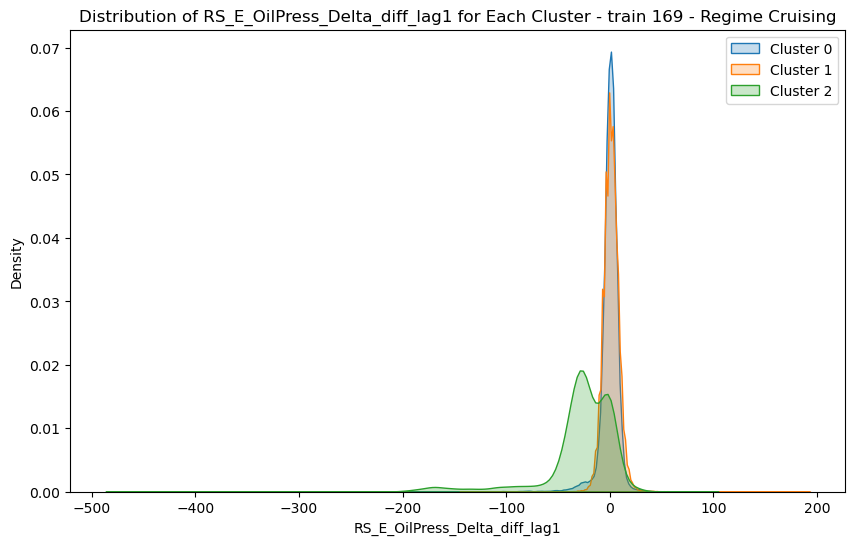

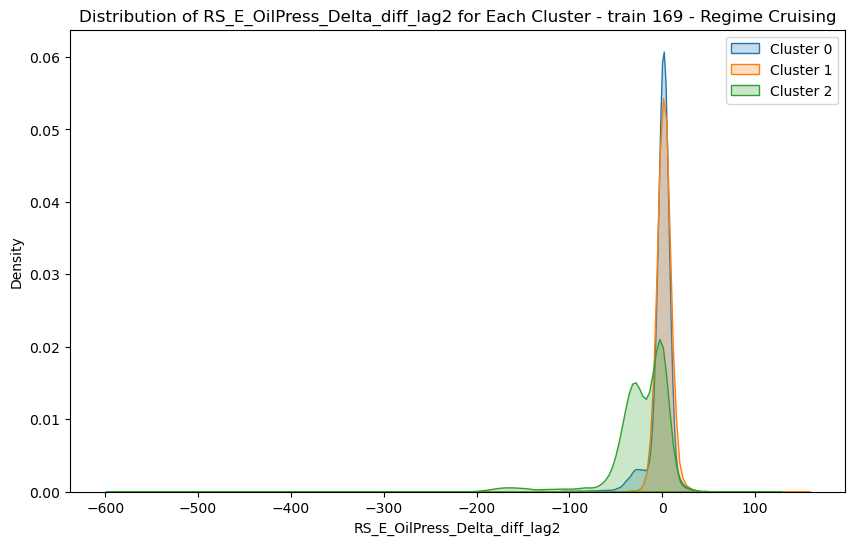

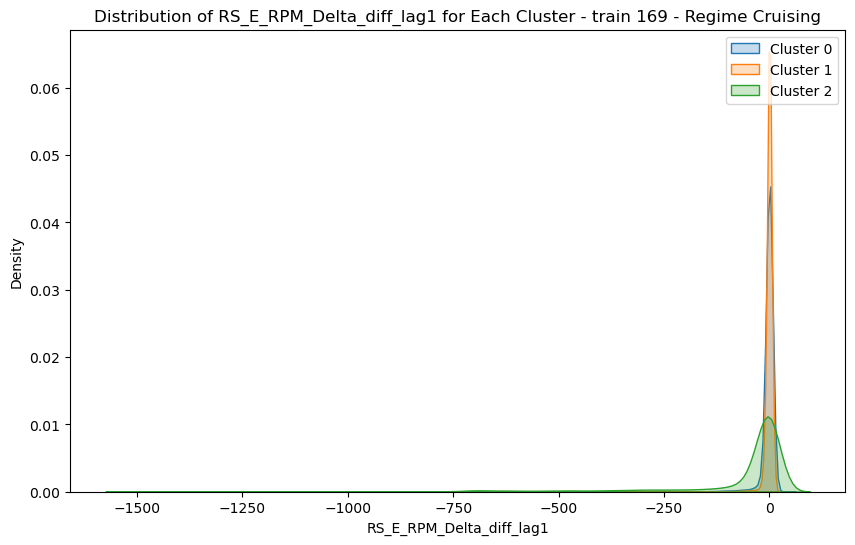

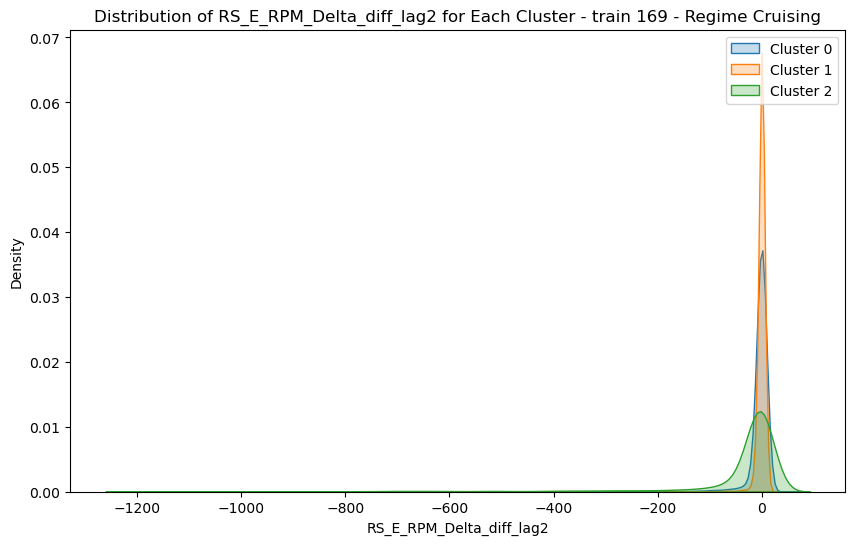

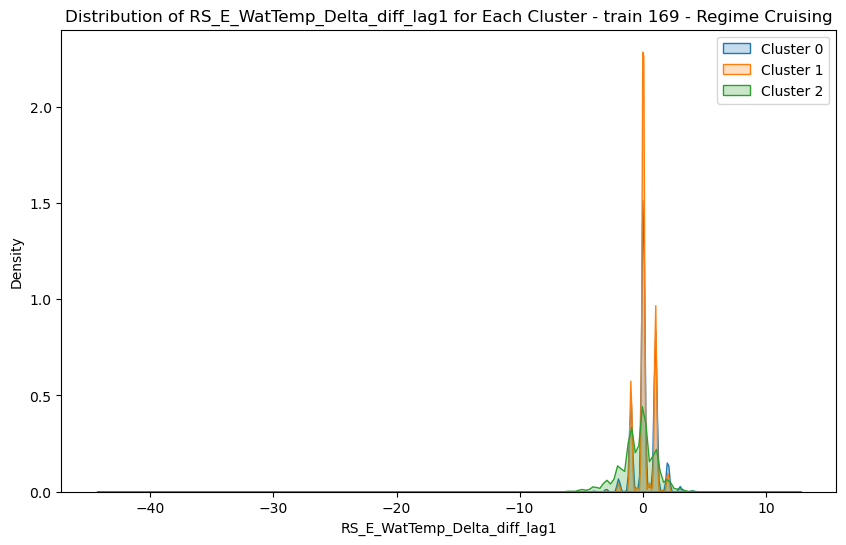

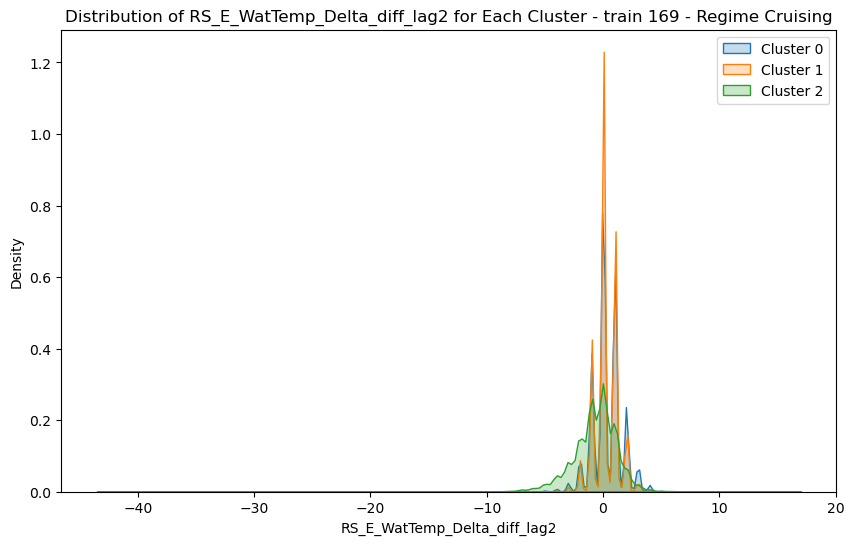

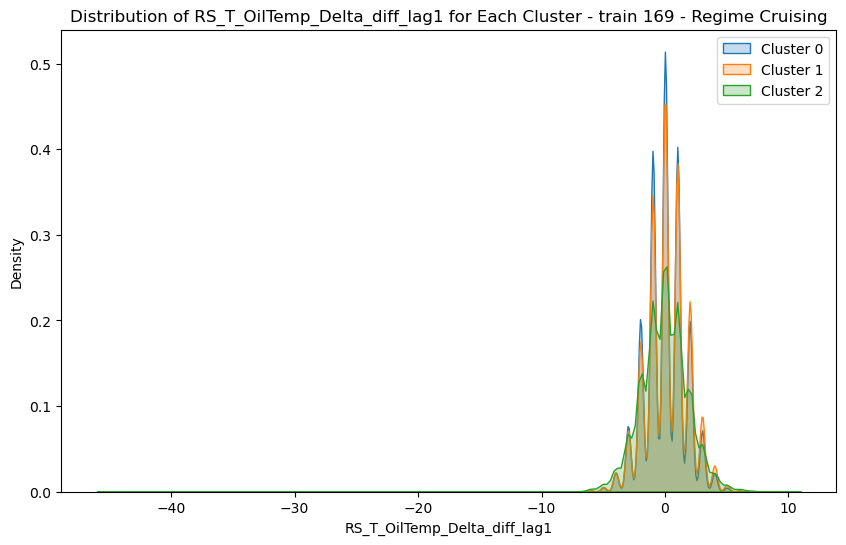

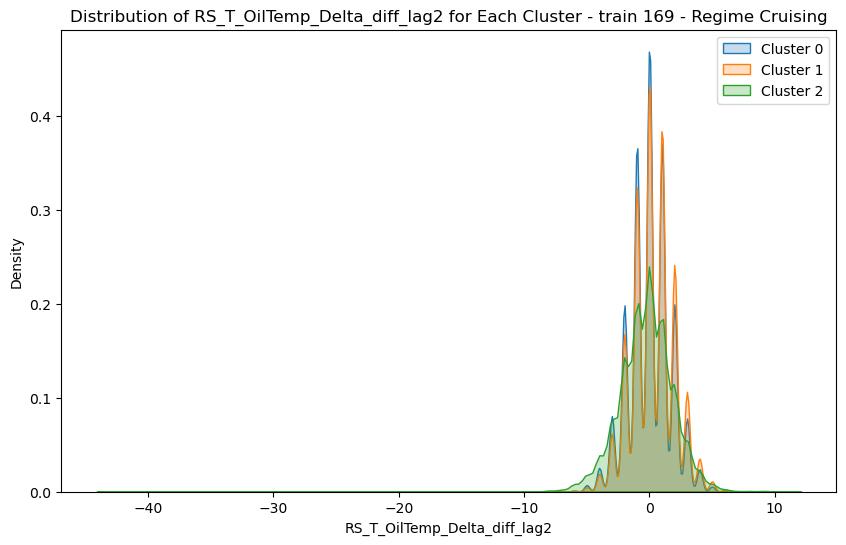

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

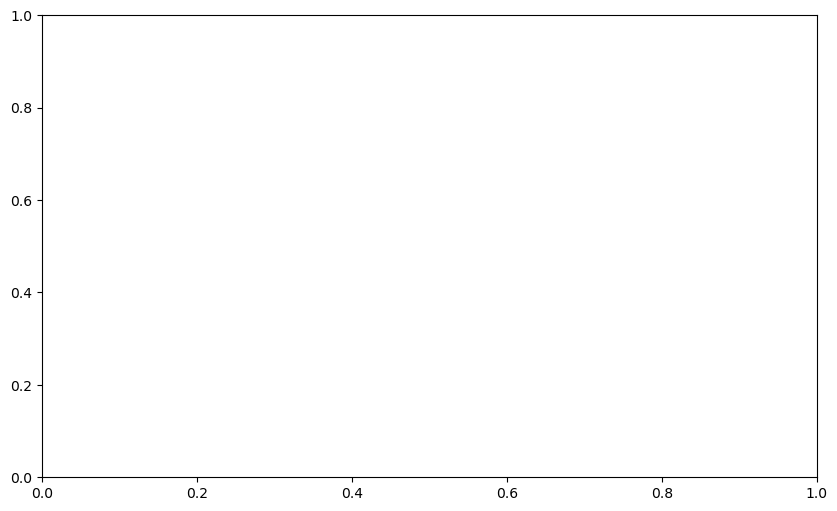

In [303]:
# Visualize the distribution of each variable for each cluster using KDE plots
for feature in df_kmeans.columns:  # Exclude the 'category' column
    plt.figure(figsize=(10, 6))
    for cluster in df_kmeans['cluster'].unique():
        sns.kdeplot(df_kmeans[feature][df_kmeans['cluster'] == cluster], label=f'Cluster {cluster}', shade=True)
    plt.title(f'Distribution of {feature} for Each Cluster - train 169 - Regime Cruising')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Anomalies

## Method 1: Isolation Forest

In [ ]:
# Apply Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
df_filtered['anomaly_score'] = clf.fit_predict(df_reconstructed)

# Visualize the anomalies
for feature in df_filtered.columns:  
    plt.figure(figsize=(10, 6))
    
    # Plot original values colored by anomaly score
    sns.scatterplot(x=df_filtered.index, y=feature, hue='anomaly_score', data=df_filtered, palette='viridis')
    
    plt.title(f'Anomaly Detection for {feature}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend(title='Anomaly Score', loc='upper right')
    plt.show()

## Method 2: Points that are significantly distant from the cluster centers can be considered outliers

In [ ]:
# Apply Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
df_filtered['anomaly_score'] = clf.fit_predict(df_reconstructed)

# Visualize the anomalies
for feature in df_filtered.columns:  
    plt.figure(figsize=(10, 6))
    
    # Plot original values colored by anomaly score
    sns.scatterplot(x=df_filtered.index, y=feature, hue='anomaly_score', data=df_filtered, palette='viridis')
    
    plt.title(f'Anomaly Detection for {feature}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend(title='Anomaly Score', loc='upper right')
    plt.show()

In [ ]:
df_filtered.columns 

In [ ]:
vars_to_plot = [ 'RS_E_InAirTemp_PC1',
       'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2',
       'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2',
       'Distance', 'IsMoving', 'RS_E_InAirTemp_Delta', 'RS_E_OilPress_Delta',
       'RS_E_RPM_Delta', 'RS_E_WatTemp_Delta', 'RS_E_InAirTemp_PC1_diff_lag1',
       'RS_E_InAirTemp_PC1_diff_lag2', 'RS_E_InAirTemp_PC2_diff_lag1',
       'RS_E_InAirTemp_PC2_diff_lag2', 'RS_E_OilPress_PC1_diff_lag1',
       'RS_E_OilPress_PC1_diff_lag2', 'RS_E_WatTemp_PC1_diff_lag1',
       'RS_E_WatTemp_PC1_diff_lag2', 'RS_T_OilTemp_PC1_diff_lag1',
       'RS_T_OilTemp_PC1_diff_lag2', 'RS_T_OilTemp_PC2_diff_lag1',
       'RS_T_OilTemp_PC2_diff_lag2', 'RS_E_InAirTemp_Delta_diff_lag1',
       'RS_E_InAirTemp_Delta_diff_lag2', 'RS_E_OilPress_Delta_diff_lag1',
       'RS_E_OilPress_Delta_diff_lag2', 'RS_E_RPM_Delta_diff_lag1',
       'RS_E_RPM_Delta_diff_lag2', 'RS_E_WatTemp_Delta_diff_lag1',
       'RS_E_WatTemp_Delta_diff_lag2', 'RS_T_OilTemp_Delta_diff_lag1',
       'RS_T_OilTemp_Delta_diff_lag2']

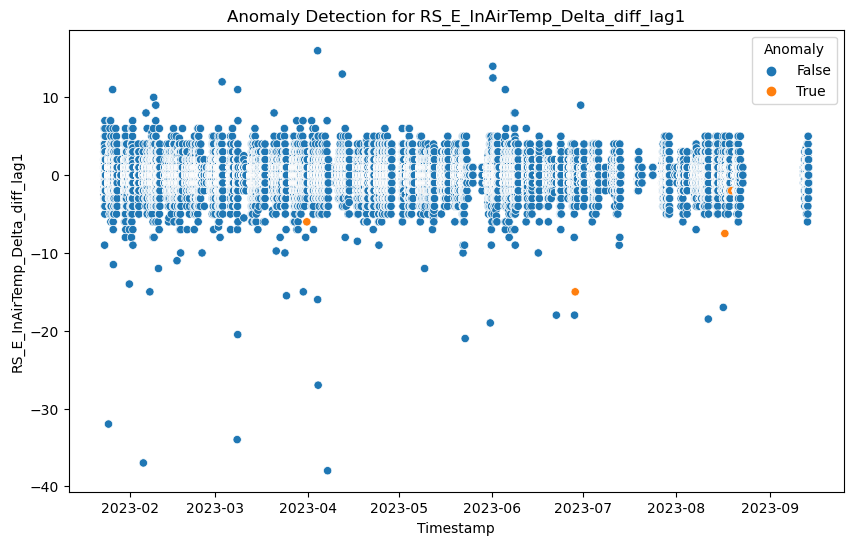

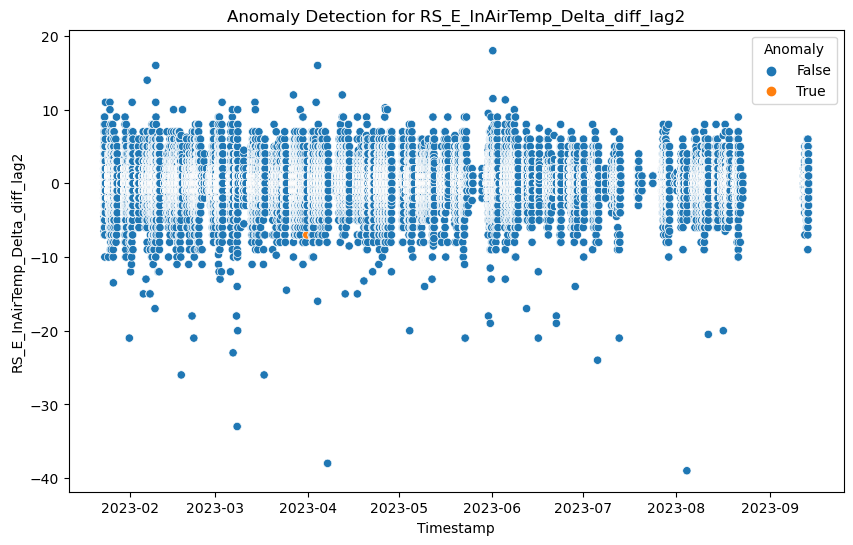

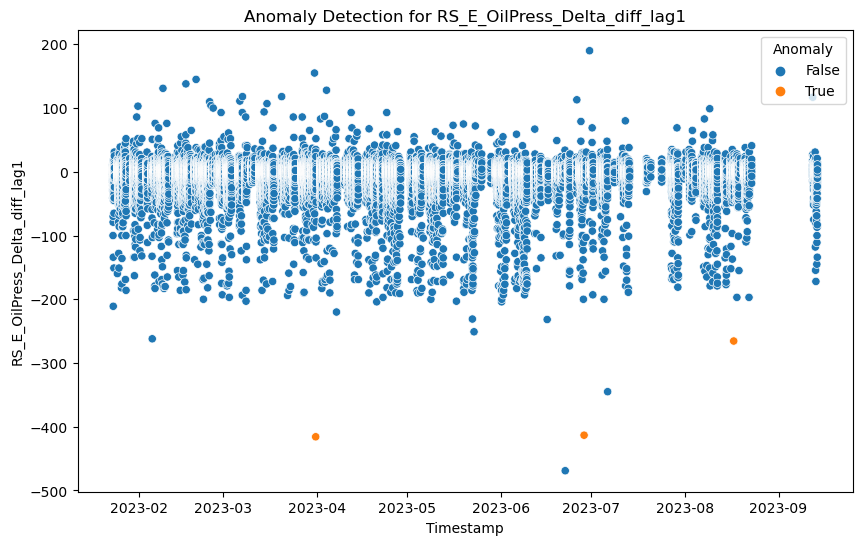

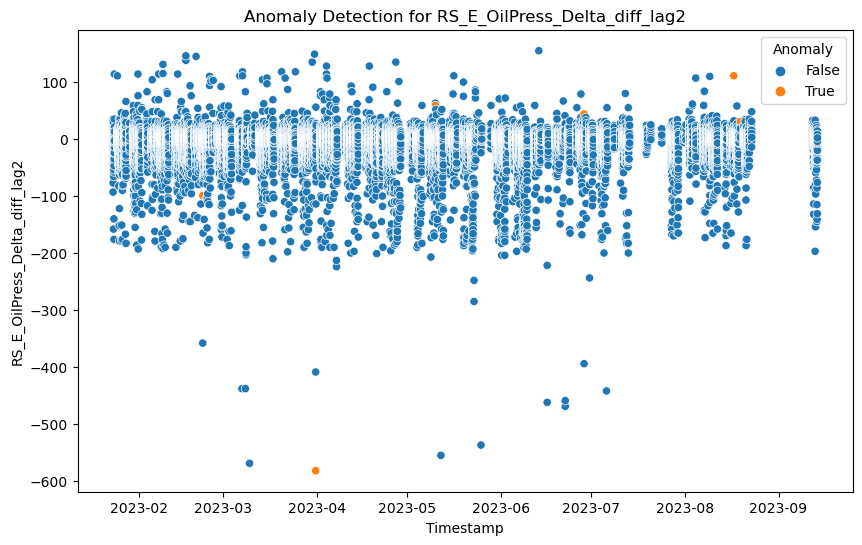

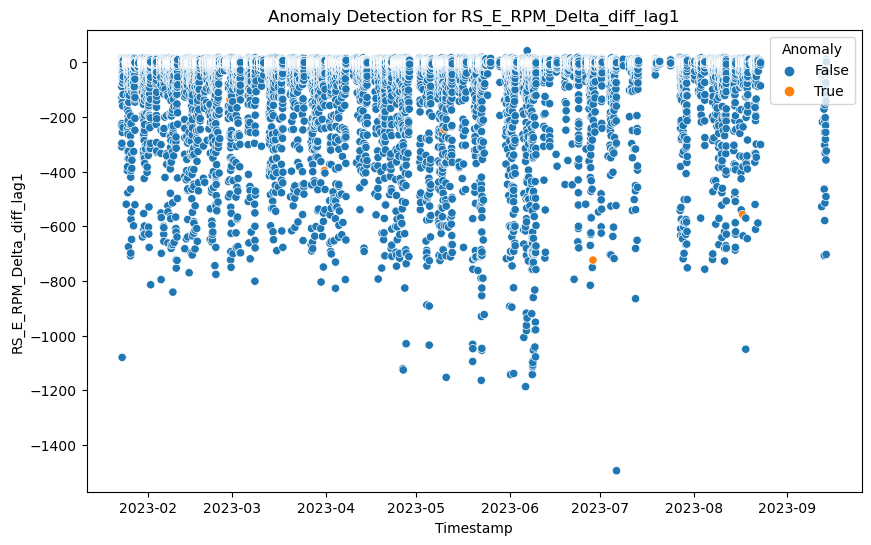

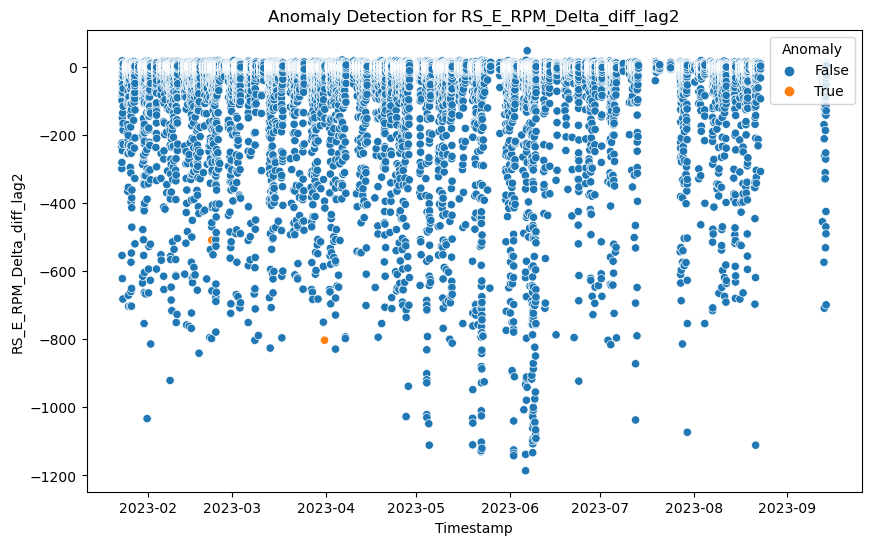

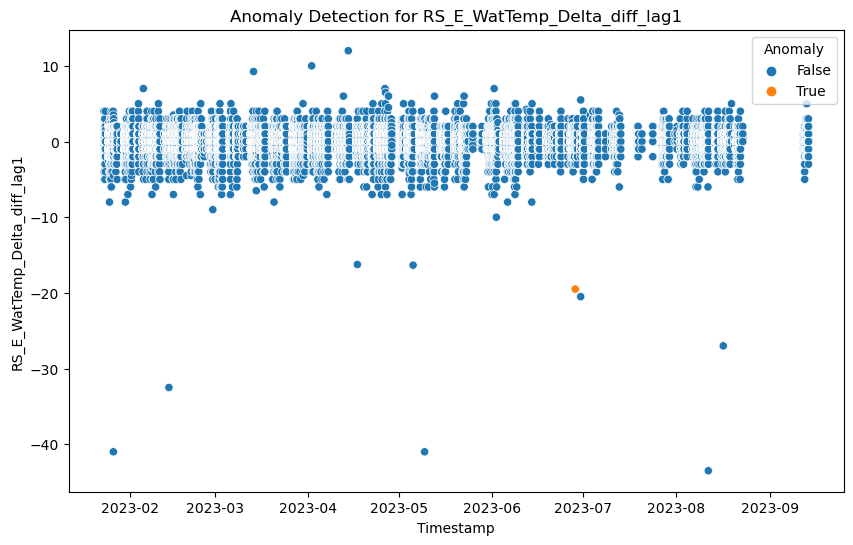

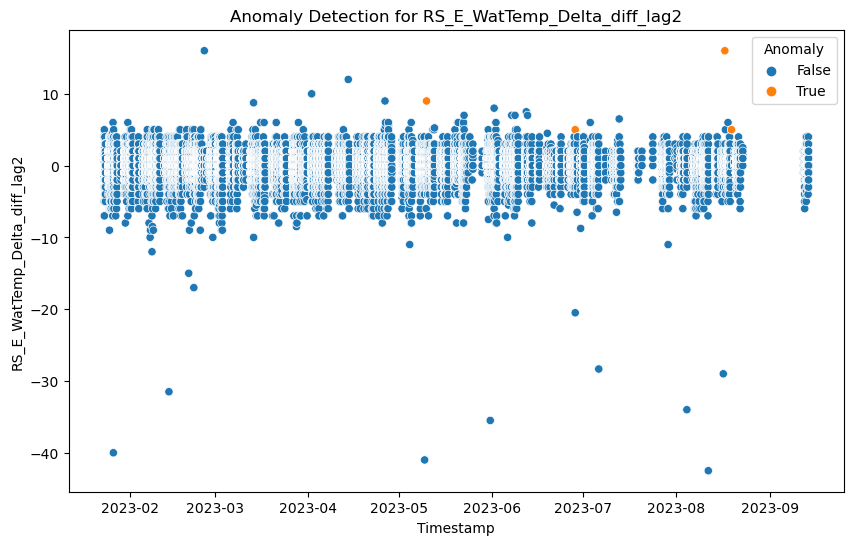

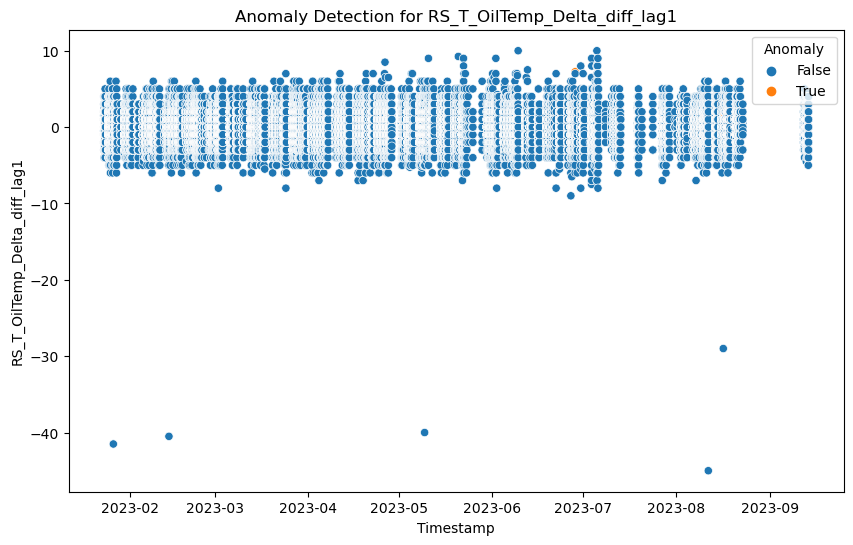

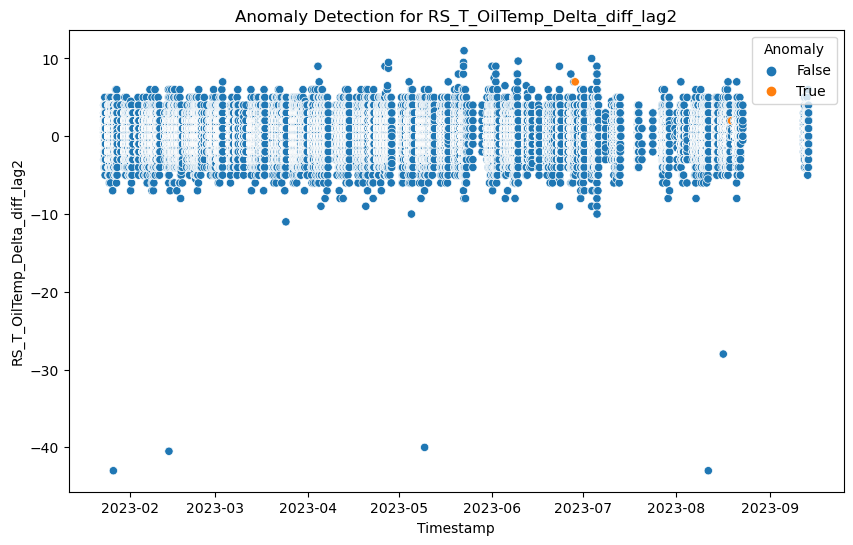

In [280]:
# Calculate distances from each point to its assigned cluster center
cluster_centers = kmeans.cluster_centers_
distances = np.linalg.norm(df_reconstructed.iloc[:, :2] - cluster_centers[df_filtered['cluster']], axis=1)
df_filtered['distance_to_center'] = distances

# Set a threshold for anomaly detection
threshold = df_filtered['distance_to_center'].sort_values(ascending=False).iloc[10]

# Identify anomalies
df_filtered['anomaly'] = df_filtered['distance_to_center'] > threshold

# Visualize the anomalies
for feature in vars_to_plot:  # Exclude the 'timestamp' column
    plt.figure(figsize=(10, 6))
    
    # Plot original values colored by anomaly status
    sns.scatterplot(x=df_filtered.index, y=feature,  hue='anomaly', data=df_filtered)
    
    plt.title(f'Anomaly Detection for {feature}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend(title='Anomaly', loc='upper right')
    plt.show()

In [ ]:
df_filtered['anomaly'].value_counts()

In [ ]:
# Plot original values colored by anomaly status
sns.scatterplot(x=df_filtered.index, y=feature,  hue='anomaly', data=df_filtered, s=7)